# Visualizing Geometric Objects with Different Coordinates

In physics, we learn how to solve Newton's second law $\vec{f} = m\vec{a}$ very early.
We often write the equation in component form, e.g.,
\begin{align}
  f_x = m a_x \\
  f_y = m a_y
\end{align}
and solve the set of multiple equations without too much thinking.
The concept of physics laws need to be independent of coordinate systems often come much later.

Some authors describe the choice of coordiante systems in general relativity as "gauge freedom" for gravity theory.
However, such a concept is does not need to be that difficult.
If some equations are capable to describe some natural phenomena, as we change our coordinate systems, we better have a way to tranform our equations so they describe the same phenomena.
Similar, if there exist some some representations to describe an object, as we change our coordinate systems, we better have a way to tranform our presentations so they describe the same object.

In this notebook, we develop these transformations in order to visualize physical (or geometrical) objects in different coordinate systems.

## Setup

Before we start, we first install and import some standard python packages.

In [1]:
! pip install jaxlib==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_releases.html
! pip install fadge matplotlib

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [2]:
%load_ext autoreload
%autoreload 2

from jax.config import config
config.update("jax_enable_x64", True)

from jax import numpy as np, jacfwd, vmap
from fadge.geode import Geode
from matplotlib import pyplot as plt

## 2D Euclidean Space

To get started, we will work with the 2D Euclidean (flat) space.
We will use both the Cartersian and polar coordinates to show how different transformation work.

We first define the coordinate maps $\varphi: (x,y) \mapsto (r,\phi)$ and the inverse map $\varphi^{-1}: (r,\phi) \mapsto (x,y)$.
They are extremely important in coordinate transformation and in some sense more fundamental than the metircs.

For convenience we also denote $\psi = \varphi^{-1}$ and $\psi^{-1} = \varphi$.

In [3]:
def car2pol(xy):
    """Coordinate map $\phi$"""
    x, y = xy
    return np.array([
        np.sqrt(x*x + y*y),
        np.arctan2(y, x),
    ])

def pol2car(rphi):
    """Inverse map $\phi^{-1}$"""
    r, phi = rphi
    return np.array([
        r * np.cos(phi),
        r * np.sin(phi),
    ])

We will also define the metrics $g_\mathrm{car}(x,y) = \mathrm{diag}(1,1)$ and $g_\mathrm{pol}(r,\phi) = \mathrm{diag}(1,r^2)$.

In [4]:
def g_car(xy):
    x, y = xy
    return np.array([
        [1, 0],
        [0, 1],
    ])

def g_pol(rphi):
    r, phi = rphi
    return np.array([
        [1, 0],
        [0, r*r],
    ])


In addition, to make our life easier with `JAX`, we define the following helper functions.

In [5]:
def vmap2(f):
    return vmap(vmap(f))

def mgrid(I, J):
    return np.einsum('ijk->jki', np.mgrid[:I,:J])

### Sampling in a Polar Grid

For the first part of the notebook, we will compute various quantities on an uniform grid in $(r, \phi)$.
We first define `sample_pol(ij)`, which takes in a `numpy` array of indices `i`, and `j`, and turn them into uniform grid points in $(r, \phi)$.
We then plot these grid points in both the "native" polar coordinates and in the (inversely) mapped cartesian coordinates.

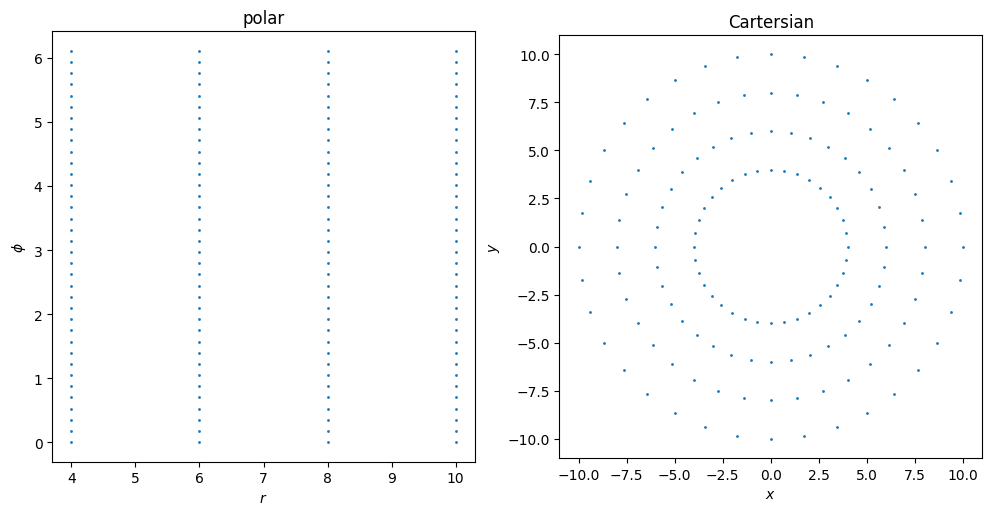

In [6]:
def sample_pol(ij):
    i, j = ij
    dr,   r0   = 2.0, 4.0
    dphi, phi0 = 2.0 * np.pi / 36, 0.0    
    return np.array([r0 + dr * i , phi0 + dphi * j])

R = vmap2(sample_pol)(mgrid(4,36))
X = vmap2(pol2car)(R)

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].scatter(R[...,0], R[...,1], s=1)
axes[0].set_title('polar')
axes[0].set_xlabel('$r$')
axes[0].set_ylabel('$\phi$')
axes[0].set_aspect('equal')

axes[1].scatter(X[...,0], X[...,1], s=1)
axes[1].set_title('Cartersian')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_aspect('equal')

### Vector Field

Next, we plot a spiral vector field, which compoents transform cotravariantly.
We define the functional form of the field $\vec{U}$ in coordinate basis in `field_pol(rphi)`.
To plot such a field in Cartersian grid, we need to apply Jacobian of the inverse coordinate map $\psi$ to $\vec{U}$.
I.e., $\vec{V} = \stackrel{\Tiny\leftrightarrow}{J_\psi} \vec{U}$.
In component form, this is
\begin{align}
  V^i = {{(J_{\psi})}^i}_a\;U^a,
\end{align}
where we follow the Einstein summation notation to sum over the dummy index $a$.

**Question:** what do we need to specify $U$ in coordiante frame instead of orthonormal frame?
What can we do to use orthonormal frame?

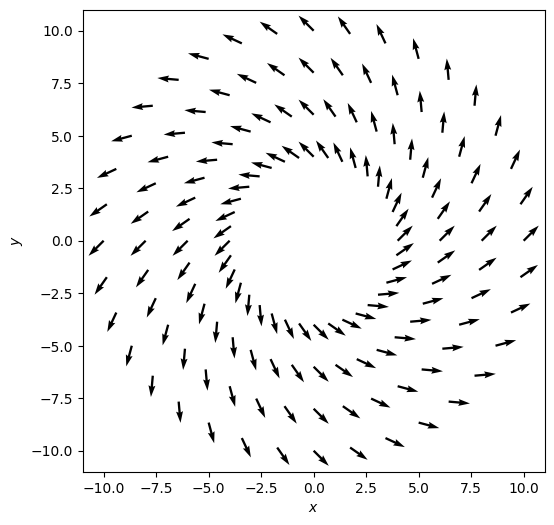

In [7]:
def field_pol(rphi):
    r, phi = rphi
    return np.array([1.0, 1 / r])

U = vmap2(field_pol)(R)
J = vmap2(jacfwd(pol2car))(R)
V = np.einsum('...ia,...a->...i', J, U)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.quiver(
    X[...,0], X[...,1],
    V[...,0], V[...,1],
)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

### Tensor Field

The metric $g$ is a tensor itself.
It therefore follows similar transformation rule as vectors, except its components transform covariantly:
\begin{align}
  (g_\mathrm{car})_{ij} = {{({J_\psi}^{-1})}_i}^a\;{{({J_\psi}^{-1})}_i}^a\;(g_\mathrm{pol})_{ab}
\end{align}
where ${{(J_\psi)}^i}_a {{({J_\psi}^{-1})}_j}^a = \delta^i_j$.
As a result, we have:
\begin{align}
 (g_\mathrm{pol})_{ij} = {{(J_\psi)}^a}_i\;{{(J_\psi)}^b}_j\;(g_\mathrm{car})_{ab}
\end{align}
Note that the summation is now done on the first index of the Jacobian.
By the same token, we can also derive:
\begin{align}
 (g_\mathrm{car})_{ij} = {{(J_\varphi)}^a}_i\;{{(J_\varphi)}^b}_j\;(g_\mathrm{pol})_{ab}
\end{align}

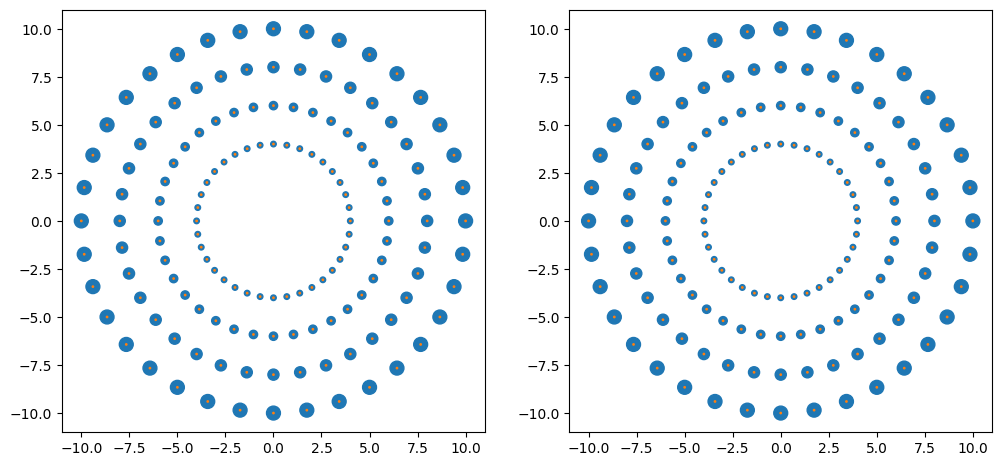

In [8]:
G_pol = vmap2(g_pol)(R)
G_car = vmap2(g_car)(X)

iJ = vmap2(jacfwd(car2pol))(X)

G_pol2 = np.einsum('...ai,...bj,...ab->...ij',  J,  J, G_car)
G_car2 = np.einsum('...ai,...bj,...ab->...ij', iJ, iJ, G_pol)

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].scatter(X[...,0], X[...,1], s=G_pol[...,1,1])
axes[0].scatter(X[...,0], X[...,1], s=G_car[...,1,1])
axes[0].set_aspect('equal')

axes[1].scatter(X[...,0], X[...,1], s=G_pol2[...,1,1])
axes[1].scatter(X[...,0], X[...,1], s=G_car2[...,1,1])
axes[1].set_aspect('equal')